### Whether Forecasting Project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set Random Seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print("="*80)
print("Pakistan Weather Forecasting with LSTM")
print("="*80)
print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")

Pakistan Weather Forecasting with LSTM
Tensorflow Version: 2.20.0
Pandas Version: 2.2.3


In [ ]:
print("\n" + "="*80)
print("STEP 01: Loading Data")
print("="*80)

data_path = "data/pakistan_weather_2000_2024.csv"
print(f"Loading data from: {data_path}")

try:
    df = pd.read_csv(data_path, parse_dates=['date'])
    print("Data Loaded Successfully!")
    print(f"Total Records : {len(df)}")
except FileNotFoundError:
    print(f"Error: File not found at path {data_path}")
    print("Please update the 'data_path' variable with correct file location")
    exit()


STEP 01: Loading Data
Loading data from: pakistan_weather_2000_2024.csv
Data Loaded Successfully!
Total Records : 31779


In [5]:
df.head()

,date,year,month,day,dayofweek,is_weekend,season,city,region,latitude,...,humidity,pressure,dew_point,cloud_cover,visibility,temp_range,is_hot_day,is_cold_day,rainfall_intensity,wind_category
0,2000-01-01,2000,1,1,5,1,Winter,Islamabad,Punjab,33.6844,...,76,1018.9,4.8,0,NaN,14.1,0,0,none,windy
1,2000-01-02,2000,1,2,6,1,Winter,Islamabad,Punjab,33.6844,...,77,1018.6,4.8,0,NaN,14.5,0,0,none,windy
2,2000-01-03,2000,1,3,0,0,Winter,Islamabad,Punjab,33.6844,...,76,1016.8,5.0,0,NaN,14.6,0,0,none,windy
3,2000-01-04,2000,1,4,1,0,Winter,Islamabad,Punjab,33.6844,...,75,1016.2,4.8,0,NaN,14.2,0,0,none,windy
4,2000-01-05,2000,1,5,2,0,Winter,Islamabad,Punjab,33.6844,...,77,1017.5,5.3,0,NaN,14.3,0,0,none,windy


In [6]:
# Basic Exploration

print(f"Dataset Shape: {df.shape} (Rows, Column)")
print("Cities In Dataset:")
if 'city' in df.columns:
    cities = df['city'].unique()
    for i, city in enumerate(cities, 1):
        count = len(df[df['city'] == city])
        print(f"    {i}. {city}: {count:,} records")

else:
    print("Warning: 'city' column not found.")

Dataset Shape: (31779, 27) (Rows, Column)
Cities In Dataset:
    1. Islamabad: 9,132 records
    2. Karachi: 5,844 records
    3. Lahore: 3,288 records
    4. Peshawar: 5,114 records
    5. Quetta: 4,018 records
    6. Gilgit: 4,383 records


In [7]:
print("Date Range:")
if 'date' in df.columns:
    print(f"    From: {df['date'].min()}")
    print(f"    To: {df['date'].max()}")

Date Range:
    From: 2000-01-01 00:00:00
    To: 2024-12-31 00:00:00


In [8]:
print(f"\n📊 Available columns:")
for col in df.columns:
    print(f"   - {col}")


📊 Available columns:
   - date
   - year
   - month
   - day
   - dayofweek
   - is_weekend
   - season
   - city
   - region
   - latitude
   - longitude
   - elevation
   - tmin
   - tmax
   - tavg
   - prcp
   - wspd
   - humidity
   - pressure
   - dew_point
   - cloud_cover
   - visibility
   - temp_range
   - is_hot_day
   - is_cold_day
   - rainfall_intensity
   - wind_category


In [9]:
print("\n" + "="*80)
print("STEP 2: DATA CLEANING")
print("="*80)

print("\nAnalyzing Your Dataset Columns...")
print("Available Columns: ", df.columns.tolist())


STEP 2: DATA CLEANING

Analyzing Your Dataset Columns...
Available Columns:  ['date', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'season', 'city', 'region', 'latitude', 'longitude', 'elevation', 'tmin', 'tmax', 'tavg', 'prcp', 'wspd', 'humidity', 'pressure', 'dew_point', 'cloud_cover', 'visibility', 'temp_range', 'is_hot_day', 'is_cold_day', 'rainfall_intensity', 'wind_category']


In [10]:
column_mapping = {
    'tavg': 'Temperature',      # Average temperature (main target)
    'humidity': 'Humidity',     # Humidity (secondary target)
    'wspd': 'Wind_Speed',       # Wind speed
    'pressure': 'Pressure',     # Atmospheric pressure
    'dew_point': 'Dew_Point',   # Dew point
    'cloud_cover': 'Cloud_Cover', # Cloud cover
    'city': 'City',             # Keep for city separation
    'date': 'Date'              # Keep for sorting
}

columns_to_keep = ['date', 'city', 'tavg', 'humidity', 'wspd', 'pressure', 'dew_point', 'cloud_cover']

# Check if all required columns exist
missing_cols = [col for col in columns_to_keep if col not in df.columns]
if missing_cols:
    print(f"WARNING: Missing columns: {missing_cols}")
    print("PLease Check your Dataset!")
    exit()


In [11]:
print("\n"+"="*80)
print("Renaming Columns")
print("="*80)

data = df[columns_to_keep].copy()

data = data.rename(columns=column_mapping)


Renaming Columns


In [12]:
print("Column Selection Complete")
print(f"    Dataset reduced from 27 columns to {len(data.columns)} columns.")

Column Selection Complete
    Dataset reduced from 27 columns to 8 columns.


In [13]:
FEATURES = ['Temperature', 'Humidity', 'Wind_Speed', 'Pressure', 'Dew_Point', 'Cloud_Cover']

# What we want to predict (OUTPUT)
TARGET_FEATURES = ['Temperature', 'Humidity']

print(f"Selected Feature for model:")
for feature in FEATURES:
    print(f"-   {feature}")

print(f"\n TARGET_FEATURES predictions:")
for target in TARGET_FEATURES:
    print(f"-   {target}")


Selected Feature for model:
-   Temperature
-   Humidity
-   Wind_Speed
-   Pressure
-   Dew_Point
-   Cloud_Cover

 TARGET_FEATURES predictions:
-   Temperature
-   Humidity


In [14]:
print("\n" + "="*80)
print("Missing Values Check")
print("="*80)


Missing Values Check


In [15]:
print("\nChecking Missing Values Check....")

missing_data = data[FEATURES].isnull().sum()
for feature in FEATURES:
    missing_count = missing_data[feature]
    missing_percent = (missing_count / len(data))* 100
    if missing_count > 0:
        print(f"    {feature}: {missing_count} {missing_percent}")
    else:
        print(f"    {feature}: No missing values...")
    


Checking Missing Values Check....
    Temperature: No missing values...
    Humidity: No missing values...
    Wind_Speed: No missing values...
    Pressure: No missing values...
    Dew_Point: No missing values...
    Cloud_Cover: No missing values...


In [16]:
# Handling Missing Values
print("Handling Missing Values...")

def handle_missing_values(city_df):
    """Fill Missing values using Forward fill and then backward fill"""

    for col in FEATURES:
        if city_df[col].isnull().sum() > 0:
            # Forward fill (use previous value)
            city_df[col].fillna(method='ffill', inplace=True)
            # Bckward fill (For any remaining at the start)
            city_df[col].fillna(method='bfill', inplace=True)
        
    return city_df

# Process each city seperatly and combine
cities = data['City'].unique()
cleanned_data = []

for city in cities:
    city_df = data[data['City'] == city]
    city_df = city_df.sort_values('Date').reset_index(drop=True)
    city_df = handle_missing_values(city_df)
    cleanned_data.append(city_df)
    print(f"Cleanned {city}: {len(city_df):,} records.")

Handling Missing Values...
Cleanned Islamabad: 9,132 records.
Cleanned Karachi: 5,844 records.
Cleanned Lahore: 3,288 records.
Cleanned Peshawar: 5,114 records.
Cleanned Quetta: 4,018 records.
Cleanned Gilgit: 4,383 records.


In [17]:
# Combine all citites back
data = pd.concat(cleanned_data, ignore_index=True)

print("\nData Cleaning Complete!")
print(f"    Total Records after cleaning: {len(data):,}")


Data Cleaning Complete!
    Total Records after cleaning: 31,779


In [18]:
print("\n"+"="*80)
print("STEP 03: CREATING SEQUENCES")
print("="*80)

seq_len = 30    #Using last 30 days to predict next day weather

print(f"Window Size: {seq_len} days")
print(f"    Input: Last {seq_len} days of {len(FEATURES)} Features.")
print(f"    Output: Next day's {len(TARGET_FEATURES)} values")


STEP 03: CREATING SEQUENCES
Window Size: 30 days
    Input: Last 30 days of 6 Features.
    Output: Next day's 2 values


In [19]:
def create_sequences(data, target_data, seq_len):
    X = []
    y = []

    for i in range(len(data) - seq_len):
        # Input: seq_length days of all features
        X.append(data[i:i+seq_len])
        # Output: next day's target values
        y.append(target_data[i+seq_len])
    
    return np.array(X), np.array(y)

# Creating Sequence for each city and combine
print(f"\nCreating Sequence for each city...")

all_X = []
all_y = []
city_info = []

for city in cities:
    city_df = data[data['City'] == city].copy()
    # Extract Feature values
    feature_data = city_df[FEATURES].values
    target_data = city_df[TARGET_FEATURES].values

    # Create Sequence
    X_City, y_City = create_sequences(feature_data, target_data, seq_len)

    all_X.append(X_City)
    all_y.append(y_City)

    city_info.append({
        'city' : city,
        'sequences' : len(X_City),
        'data_range' : f"{city_df['Date'].iloc[0].date()} to {city_df['Date'].iloc[-1].date()}" 
    })

    print(f"    {city}: {len(X_City):,} sequences created")

# Combine all sequences

X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0)

print(f"\n  Total Sequences Created : {len(X):,}")
print(f"    X shape: {X.shape} (sequences, timestep, features)")
print(f"    Y shape: {y.shape} (sequences, targets)")


Creating Sequence for each city...
    Islamabad: 9,102 sequences created
    Karachi: 5,814 sequences created
    Lahore: 3,258 sequences created
    Peshawar: 5,084 sequences created
    Quetta: 3,988 sequences created
    Gilgit: 4,353 sequences created

  Total Sequences Created : 31,599
    X shape: (31599, 30, 6) (sequences, timestep, features)
    Y shape: (31599, 2) (sequences, targets)


In [20]:
print("\n" + "="*80)
print("STEP 4: SPLITTING DATA")
print("="*80)

Train_Ratio = 0.7
Val_Ratio = 0.15
Test_Ratio = 0.15

print(f"    Train: {Train_Ratio*100:,}%")
print(f"    Validation: {Val_Ratio*100:,}%")
print(f"    Test: {Test_Ratio:,}%")

print(f"\n  Time Based Split (No Shuffling!)")

#Calculate split indices
n_samples = len(X)
train_end = int(n_samples*Train_Ratio)
val_end = int(n_samples*(Train_Ratio + Val_Ratio))

# Split the data
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

print(f"    Data Split Complete!")
print(f"    Train: {len(X_train):,} sequences ({(len(X_train)/n_samples)*100:.1f}%)")
print(f"    Validation: {len(X_val):,} sequences ({(len(X_val)/n_samples)*100:.1f} %)")
print(f"    Test: {len(X_test):,} sequences ({(len(X_test)/n_samples)*100:.1f}%)")


STEP 4: SPLITTING DATA
    Train: 70.0%
    Validation: 15.0%
    Test: 0.15%

  Time Based Split (No Shuffling!)
    Data Split Complete!
    Train: 22,119 sequences (70.0%)
    Validation: 4,740 sequences (15.0 %)
    Test: 4,740 sequences (15.0%)


In [21]:
print("\n" + "="*80)
print("STEP 5: SCALING FEATURES")
print("="*80)

print(f"\n   Scaling all Features to [0, 1] range")
print(f"    Fitting scaller only on Training data!")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Dimensions
n_samples_train, n_timesteps, n_features =  X_train.shape
# Reshape for scaling (2D)
X_train_reshaped = X_train.reshape(-1, n_features)
X_val_reshaped = X_val.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

print(f"Scaling Input features..")
# Fit on training data and transform all sets
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_val_scaled = scaler_X.transform(X_val_reshaped)
X_test_scaled = scaler_X.transform(X_test_reshaped)

# Reshape back to 3D: (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)
X_val_scaled = X_val_scaled.reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], n_timesteps, n_features)

print(f"    Input Features scaled..")

print(f"\n  Scaling Target values..")
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

print(f"    Target Features scaled..")

# Saving scalers for later use
print(f"\nSaving Scaler...")
import os
os.makedirs('models', exist_ok=True)

with open('models/scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('models/scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print(f"   Scalers saved to 'models/' directory")

print(f"\n Scaling complete!")
print(f"   All values now in range [0, 1]")



STEP 5: SCALING FEATURES

   Scaling all Features to [0, 1] range
    Fitting scaller only on Training data!
Scaling Input features..
    Input Features scaled..

  Scaling Target values..
    Target Features scaled..

Saving Scaler...
   Scalers saved to 'models/' directory

 Scaling complete!
   All values now in range [0, 1]


In [22]:
print("\n" + "="*80)
print("STEP 6: BUILDING LSTM MODEL")
print("="*80)

# Model Configuration
LSTM_units_1 = 64  # First LSTM Layer
LSTM_units_2 = 32  # Second LSTM Layer
Dropout_rate = 0.2
n_outputs = len(TARGET_FEATURES)    # Number of outputs (2: temp & humidity)

print(f"\nMODEL ARCHITECTURE..")
print(f"    Input Shape: ({seq_len}, {len(FEATURES)})")
print(f"    LSTM Layer 1: {LSTM_units_1} units + Dropout({Dropout_rate})")
print(f"    LSTM Layer 2: {LSTM_units_2} units + Dropout({Dropout_rate})")
print(f"    Output Layer: {n_outputs} units (Temperature & Humidity)")

# Model
model = Sequential([
    # First LSTM layer - returns sequences for next layer
    LSTM(LSTM_units_1, return_sequences=True, input_shape= (seq_len, len(FEATURES)), name='lstm_layer_1'),
    # Droput to prevent overfitting
    Dropout(Dropout_rate, name='Dropout_1'),

    # Second LSTM layer - returns final state only
    LSTM(LSTM_units_2, return_sequences=False, name='lstm_unit_2'),
    Dropout(Dropout_rate, name='Dropout_2'),

    # Output Layer consist of 2 neurons for temperature and humidity
    Dense(n_outputs, name='output_layer')
])

# Compiling The Model
print(f"\nCompiling the Model..")
model.compile(optimizer='adam', loss='mse', metrics=['mae'])       # adam optimizer -> adaptive learning rate.

print(f"    Model Compiled Successfully!!")

print("\nMODEL SUMMARY:")
print("="*80)
model.summary()
print("="*80)

#count parameters
total_params = model.count_params()
print(f"\nTotal Trainable Parameters: {total_params:,}")


STEP 6: BUILDING LSTM MODEL

MODEL ARCHITECTURE..
    Input Shape: (30, 6)
    LSTM Layer 1: 64 units + Dropout(0.2)
    LSTM Layer 2: 32 units + Dropout(0.2)
    Output Layer: 2 units (Temperature & Humidity)

Compiling the Model..
    Model Compiled Successfully!!

MODEL SUMMARY:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 30, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_unit_2 (LSTM)              │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,658 (119.76 KB)

 Trainable params: 30,658 (119.76 KB)

 Non-trainable params: 0 (0.00 B)


Total Trainable Parameters: 30,658


In [23]:
print("\n" + "="*80)
print("STEP 07: TRAINING THE MODEL")
print("="*80)

# Training
Epochs = 100
Batch_Size = 32

print(f"\nTraining Configuration:")
print(f"Epochs: {Epochs}")
print(f"Batch Size: {Batch_Size}")
print(f"Optimizer: Adam")
print(f"Loss Function: MSE")
print(f"Metrics: MAE")

# Creating Directory For Saving the Model
os.makedirs('models/saved_models', exist_ok=True)
#setup callbacks
callbacks = [
    #save the best model based on validation loss
    ModelCheckpoint(
        filepath='models/saved_models/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    # Stop Training When validation Loss doesnot improve
    EarlyStopping(
        monitor='val_loss',
        patience=15,                # Stop if no improvement for 15 epochs
        restore_best_weights=True,  # It will restore weights from best epochs
        verbose=1
    )
]

print(f"\n Callbacks configured:")
print(f"   -> ModelCheckpoint: Saves best model")
print(f"   -> EarlyStopping: Patience = 15 epochs")

print(f"\n Starting training...")
print(f"   This may take 20-40 minutes depending on hardware")
print("="*80)

# Training the Model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs = Epochs,
    batch_size = Batch_Size,
    callbacks=callbacks,
    verbose=1
)

print("="*80)
print("Traing Completeed!!")

# Best epoch info
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
print(f"\n  Best model Performance:")
print(f"    Best Epoch: {best_epoch}")
print(f"    Best Validation Loss: {best_val_loss:.6f}")



STEP 07: TRAINING THE MODEL

Training Configuration:
Epochs: 100
Batch Size: 32
Optimizer: Adam
Loss Function: MSE
Metrics: MAE

 Callbacks configured:
   -> ModelCheckpoint: Saves best model
   -> EarlyStopping: Patience = 15 epochs

 Starting training...
   This may take 20-40 minutes depending on hardware
Epoch 1/100
689/692 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0268 - mae: 0.1173
Epoch 1: val_loss improved from None to 0.01226, saving model to models/saved_models/best_model.keras
692/692 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0155 - mae: 0.0939 - val_loss: 0.0123 - val_mae: 0.0820
Epoch 2/100
690/692 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0099 - mae: 0.0766
Epoch 2: val_loss improved from 0.01226 to 0.01020, saving model to models/saved_models/best_model.keras
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.0094 - mae: 0.0742 - val_loss: 0.0102 - val_mae: 0.0750
Epoch 3/100
691/692 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0075 - mae: 0.0661
Epoch 3: val_lo

In [24]:
print("\n" + "="*80)
print("STEP 8: EVALUATING MODEL")
print("="*80)

print(f"\nMaking Predictions on all Datasets...")

y_train_pred_scaled = model.predict(X_train_scaled, verbose=1)
y_val_pred_scaled = model.predict(X_val_scaled, verbose=1)
y_test_pred_scaled = model.predict(X_test_scaled, verbose=1)

# Inverse Transform to get the actual Values
print(f"    Training Set Predictions")
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

print(f"    Validation Set Predictions")
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

print(f"    Test Set Predictions")
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

print(f"\nPredictions complete!")

# Calculating Metrics

def calculate_metrics(y_true, y_pred, set_name):
    #Temprature metrics
    temp_rmse = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
    temp_mae = mean_absolute_error(y_true[:,0], y_pred[:,0])
    temp_r2 = r2_score(y_true[:,0], y_pred[:,0])

    # Humidity metrics 
    humid_rmse = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))
    humid_mae = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    humid_r2 = r2_score(y_true[:, 1], y_pred[:, 1])

    print(f"\n{set_name} Set Metrics:")
    print(f"="*60)

    print(f"    TEMPERATURE:")
    print(f"      RMSE: {temp_rmse:.3f}°C")
    print(f"      MAE:  {temp_mae:.3f}°C")
    print(f"      R²:   {temp_r2:.3f}")
    print(f"\n  HUMIDITY:")
    print(f"      RMSE: {humid_rmse:.3f}%")
    print(f"      MAE:  {humid_mae:.3f}%")
    print(f"      R²:   {humid_r2:.3f}")

    return {
        'Set': set_name,
        'Temperature_RMSE': temp_rmse,
        'Temperature_MAE': temp_mae,
        'Temperature_R2': temp_r2,
        'Humidity_RMSE': humid_rmse,
        'Humidity_MAE': humid_mae,
        'Humidity_R2': humid_r2
    }

print("=" * 80)

# Calculate Metrics for all sets
train_metrics = calculate_metrics(y_train, y_train_pred, "TRAIN")
Val_metrics = calculate_metrics(y_val, y_val_pred, "VALIDATION")
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST")

# Save Metrics to CSV
metrics_df = pd.DataFrame([train_metrics, Val_metrics, test_metrics])
metrics_df.to_csv('models/metrics.csv', index = False)
print(f"Metrics saved to models/metrics.csv")

# Check if we achieved our goal
print(f"\n GOAL ACHIEVEMENT:")
if test_metrics['Temperature_RMSE'] < 3.0:
    print(f"    Temperature RMSE < 3°C: {test_metrics['Temperature_RMSE']:.3f}°C")
else:
    print(f"    Temperature RMSE ≥ 3°C: {test_metrics['Temperature_RMSE']:.3f}°C")


STEP 8: EVALUATING MODEL

Making Predictions on all Datasets...
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
    Training Set Predictions
    Validation Set Predictions
    Test Set Predictions

Predictions complete!

TRAIN Set Metrics:
    TEMPERATURE:
      RMSE: 1.050°C
      MAE:  0.790°C
      R²:   0.979

  HUMIDITY:
      RMSE: 6.275%
      MAE:  4.582%
      R²:   0.856

VALIDATION Set Metrics:
    TEMPERATURE:
      RMSE: 1.461°C
      MAE:  1.090°C
      R²:   0.972

  HUMIDITY:
      RMSE: 8.986%
      MAE:  7.032%
      R²:   0.794

TEST Set Metrics:
    TEMPERATURE:
      RMSE: 2.497°C
      MAE:  1.775°C
      R²:   0.953

  HUMIDITY:
      RMSE: 8.536%
      MAE:  6.700%
      R²:   0.724
Metrics saved to models/metrics.csv

 GOAL ACHIEVEMENT:
    Temperature RMSE < 3°C: 2.497°C


In [25]:
print("\n" + "="*80)
print("STEP 9: CREATING VISUALIZATIONS")
print("="*80)

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Training History
print(f"\n📊 Creating training history plots...")



STEP 9: CREATING VISUALIZATIONS

📊 Creating training history plots...


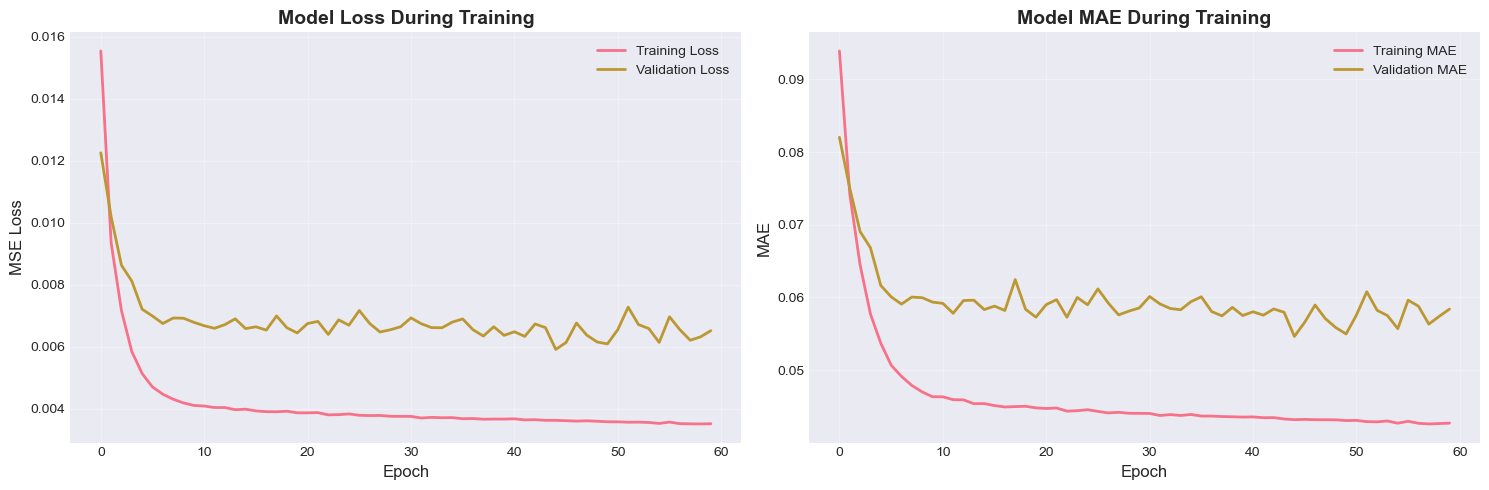

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss Plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label = 'Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label = 'Validation MAE', linewidth=2)
axes[1].set_title('Model MAE During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [27]:
plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: models/training_history.png")
plt.close()

   ✅ Saved: models/training_history.png



📊 Creating prediction comparison plots...


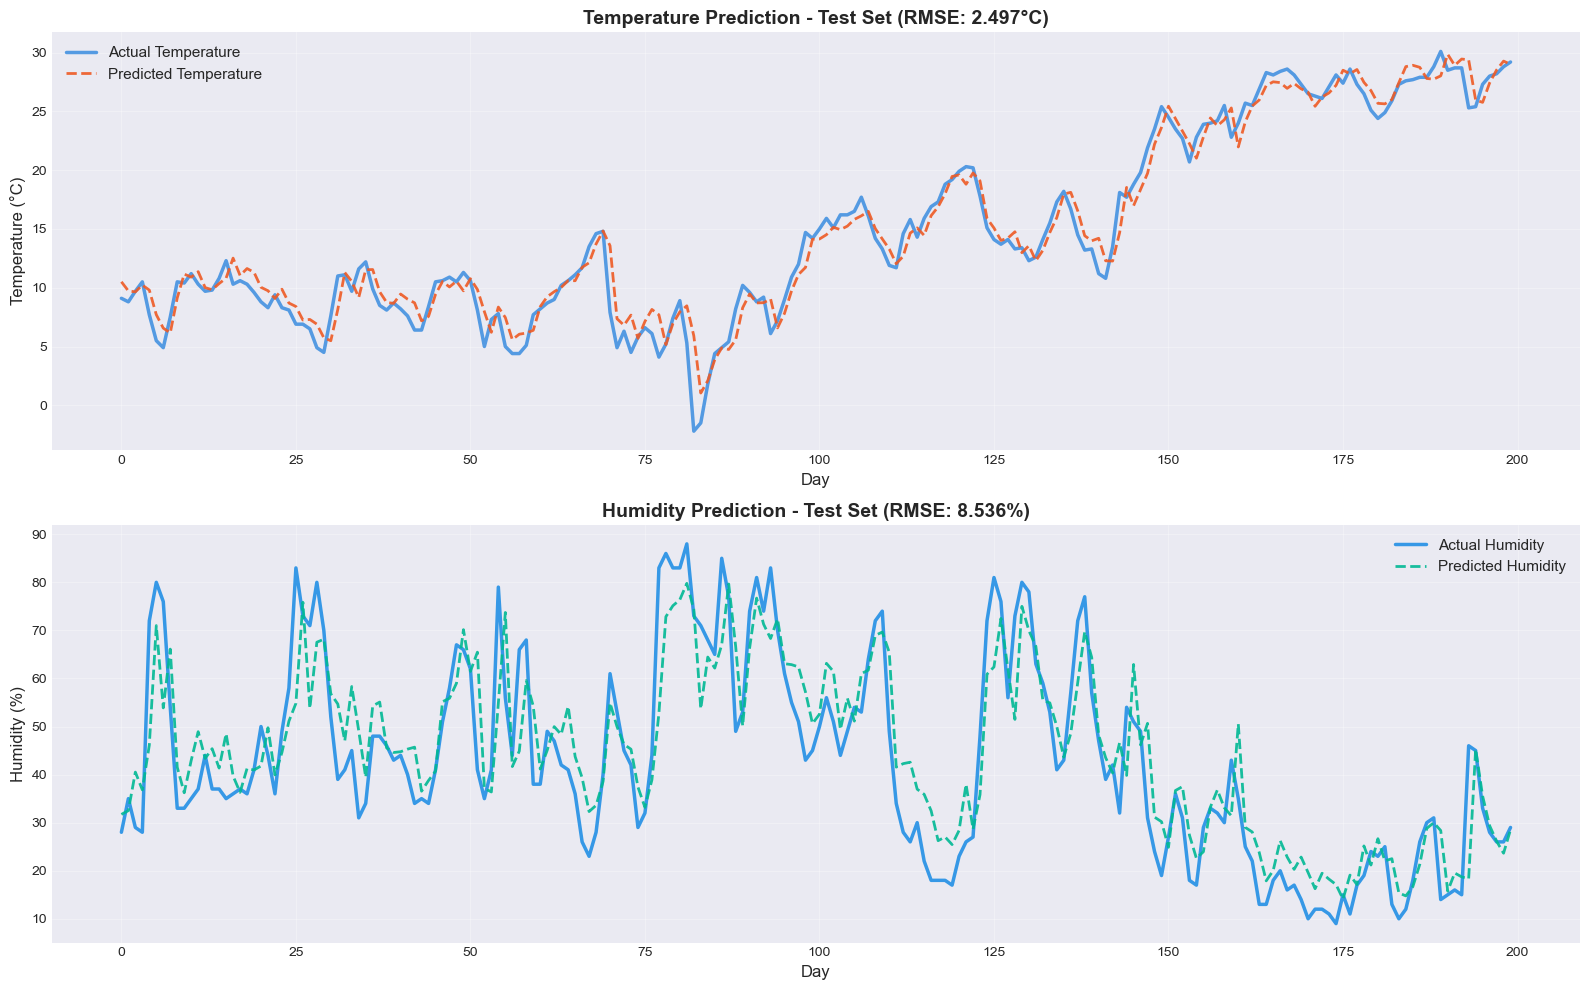

In [28]:
# 2. Predictions vs Actual
print(f"\n📊 Creating prediction comparison plots...")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Show first 200 samples from test set
sample_size = min(200, len(y_test))

# Temperature plot
axes[0].plot(y_test[:sample_size, 0], 
             label='Actual Temperature', 
             linewidth=2.5, 
             color='#2E86DE', 
             alpha=0.8)
axes[0].plot(y_test_pred[:sample_size, 0], 
             label='Predicted Temperature', 
             linewidth=2, 
             color='#EE5A24', 
             linestyle='--', 
             alpha=0.9)
axes[0].set_title(f'Temperature Prediction - Test Set (RMSE: {test_metrics["Temperature_RMSE"]:.3f}°C)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3)

# Humidity plot
axes[1].plot(y_test[:sample_size, 1], 
             label='Actual Humidity', 
             linewidth=2.5, 
             color='#0984E3', 
             alpha=0.8)
axes[1].plot(y_test_pred[:sample_size, 1], 
             label='Predicted Humidity', 
             linewidth=2, 
             color='#00B894', 
             linestyle='--', 
             alpha=0.9)
axes[1].set_title(f'Humidity Prediction - Test Set (RMSE: {test_metrics["Humidity_RMSE"]:.3f}%)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Humidity (%)', fontsize=12)
axes[1].legend(fontsize=11, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [29]:
plt.savefig('models/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: models/predictions_vs_actual.png")
plt.close()

   ✅ Saved: models/predictions_vs_actual.png



📊 Creating scatter plots...


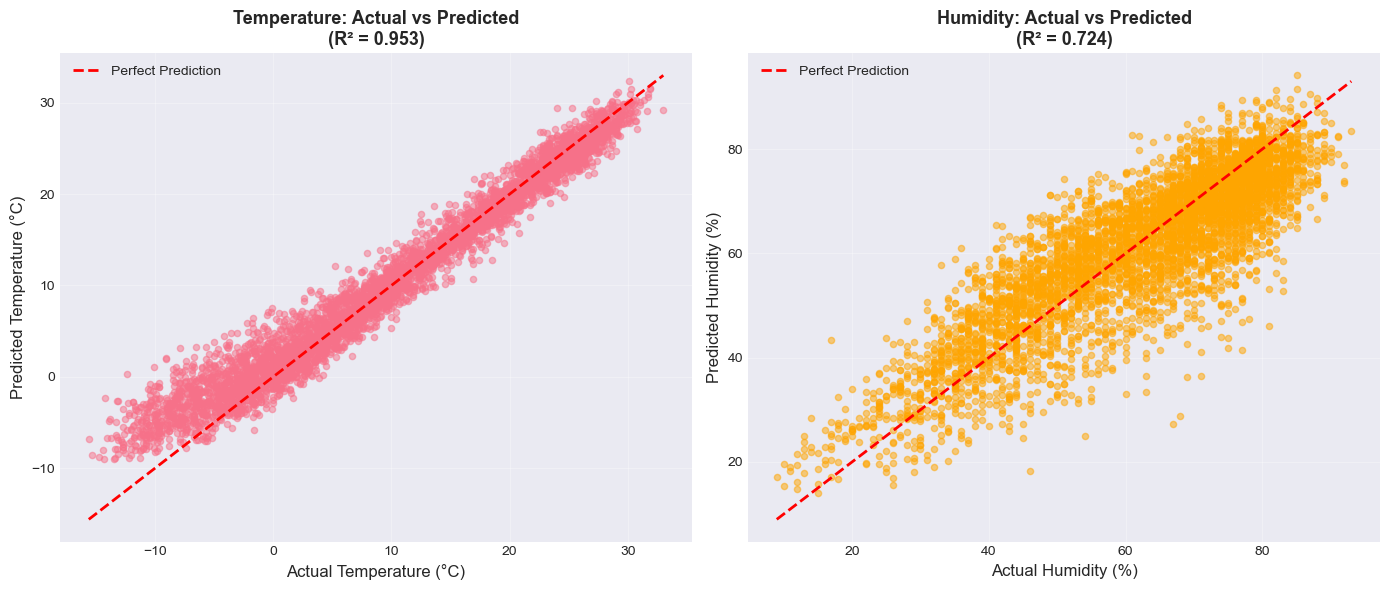

In [30]:
# 3. Scatter plots
print(f"\n📊 Creating scatter plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature scatter
axes[0].scatter(y_test[:, 0], y_test_pred[:, 0], alpha=0.5, s=20)
axes[0].plot([y_test[:, 0].min(), y_test[:, 0].max()], 
             [y_test[:, 0].min(), y_test[:, 0].max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Temperature (°C)', fontsize=12)
axes[0].set_title(f'Temperature: Actual vs Predicted\n(R² = {test_metrics["Temperature_R2"]:.3f})', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Humidity scatter
axes[1].scatter(y_test[:, 1], y_test_pred[:, 1], alpha=0.5, s=20, color='orange')
axes[1].plot([y_test[:, 1].min(), y_test[:, 1].max()], 
             [y_test[:, 1].min(), y_test[:, 1].max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Humidity (%)', fontsize=12)
axes[1].set_ylabel('Predicted Humidity (%)', fontsize=12)
axes[1].set_title(f'Humidity: Actual vs Predicted\n(R² = {test_metrics["Humidity_R2"]:.3f})', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [31]:
plt.savefig('models/scatter_plots.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: models/scatter_plots.png")
plt.close()


   ✅ Saved: models/scatter_plots.png



📊 Creating error distribution plots...


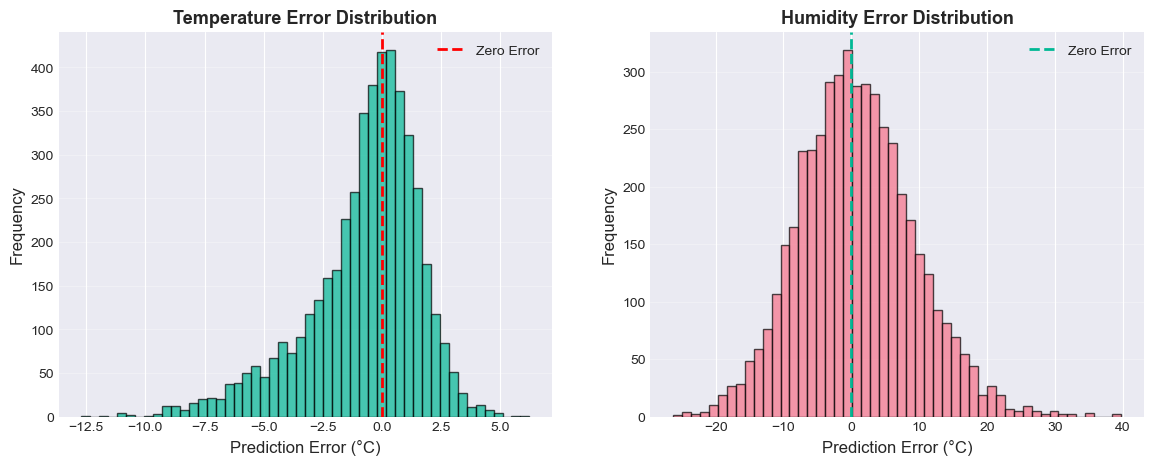

In [32]:
print(f"\n📊 Creating error distribution plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temperature errors
temp_errors = y_test[:, 0] - y_test_pred[:, 0]
axes[0].hist(temp_errors, bins=50, edgecolor='black', alpha=0.7,color='#00B894')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (°C)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Temperature Error Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

humid_errors = y_test[:, 1] - y_test_pred[:, 1]
axes[1].hist(humid_errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='#00B894', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (°C)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Humidity Error Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')